In [3]:
path_to_styles = '/Users/akhiljalan/Downloads/describable_textures_styles/images/'
path_to_img_stylization = '/Users/akhiljalan/Programming/_wip/magenta/magenta/models/image_stylization'
path_to_styled_images = '/Users/akhiljalan/Downloads/trainingdata_stylized_500/stylized500/'
pbn_path = '/Users/akhiljalan/Downloads/pbn_styles_train1/'

In [4]:
path_to_tripled_data = '/Users/akhiljalan/Downloads/traindata3/train0/'

In [5]:
import sys
import os
import numpy as np
sys.path.append(path_to_styles)
sys.path.append(path_to_img_stylization)

In [6]:
import tensorflow as tf

In [7]:
slim = tf.contrib.slim

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
sys.path.append('../../magenta/magenta/models/arbitrary_image_stylization/')
sys.path.append('../../magenta/magenta/models/image_stylization/')

In [67]:
from image_utils import *

# A Test of A Simple GAN

We'll try to distinguish between 2D vectors genereated from a normal distribution and those that aren't. This is for simplicity. 

## Notes

* There has to be some way of getting variables whose scope is the discriminator, and those whose scope is the generator. This is because the losses can be functions of both. Right now we're passing in names to tf.layers, a fairly clunky way of doing this...

In [10]:
np.random.multivariate_normal(np.array([0, 0]), cov=np.eye(2), size=16)

array([[ 0.27662131,  1.1058651 ],
       [-0.37469513,  0.83631796],
       [-1.64174562,  1.72446632],
       [ 0.58318962,  0.12278274],
       [-0.14817582,  1.09393911],
       [ 0.12112453,  1.29451825],
       [-0.52284206,  0.58005387],
       [ 1.29885546,  0.77721871],
       [-0.20359832, -0.26165039],
       [ 1.1197701 , -0.70721645],
       [-1.31366685,  0.15975117],
       [-0.84114321,  0.27368119],
       [-0.8711692 ,  0.14966791],
       [-2.18328996,  2.89951887],
       [ 1.03443234,  1.30770999],
       [-1.00917615,  0.68354283]])

In [13]:
np.repeat(np.array([[0, 1]]), 5, axis=0)

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [14]:
def gen_real_normals(batch_size=50): 
    normals = np.random.multivariate_normal(np.array([0, 0]), cov=np.eye(2), size=batch_size)
    labels = np.repeat(np.array([[1.0, 0.0]]), batch_size, axis=0)
    return normals, labels

In [76]:
def gen_uniform_noise(batch_size=50): 
    vals =  np.random.uniform(low = 10, high = 20, size = batch_size * 2).reshape(batch_size, 2)
    labels = np.repeat(np.array([[0.0, 1.0]]), batch_size, axis=0)
    return vals, labels

In [50]:
def discriminator(input_batch, reuse=False): 
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('discr'), tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
        out1 = tf.layers.dense(input_batch, 10, activation=tf.nn.relu, name='disc_1')
        logits = tf.layers.dense(out1, 2, name='disc_2')
        return logits

In [51]:
def generator(noise_batch, reuse=False): 
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('genr_') as name_scopes, tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
        out1 = tf.layers.dense(noise_batch, 10, activation=tf.sigmoid, name='gen_1')
        out2 = tf.layers.dense(out1, 2, name='gen_2')
        return out2

In [82]:
x_placeholder = tf.placeholder("float", shape=[None, 2], name='x_placeholder')
noise_placeholder = tf.placeholder("float", shape=[None, 2], name='noise_placeholder')
real_labels = tf.placeholder("float", shape=[None, 2], name='real_labels_placeholder')
fake_labels = tf.placeholder("float", shape=[None, 2], name='fake_labels_placeholder')

z_gen = generator(noise_placeholder)
discr_x = discriminator(x_placeholder)
discr_g = discriminator(z_gen)



d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discr_x, labels=real_labels))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discr_g, labels=fake_labels))
d_loss = d_loss_real + d_loss_fake

# Want logits of fake digits to match the "real" labels 
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discr_g, labels=real_labels))

trainable_vars = tf.trainable_variables()
d_vars = [var for var in trainable_vars if 'disc_' in var.name]
g_vars = [var for var in trainable_vars if 'gen_' in var.name]

with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE) as scope:
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

    # Train the generator
    # Decreasing from 0.004 in GitHub version
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

init_op = tf.global_variables_initializer()

In [91]:
fake_losses = []
real_losses = []
gen_losses = []

In [99]:
tf.constant(np.repeat(np.array([[1.0, 0.0]]), 5, axis=0))

<tf.Tensor 'Const_20:0' shape=(5, 2) dtype=float64>

In [92]:
with tf.Session() as sess: 
    sess.run([init_op])
    for i in range(20000): 
        for k in range(4): 
            z_noise, fake_pt_labels = gen_uniform_noise(16)
            x_real, real_pt_labels = gen_real_normals(16)
            fake_loss, real_loss, _, _ = sess.run([d_loss_fake, d_loss_real, d_trainer_fake, d_trainer_real], 
                                                   feed_dict = {x_placeholder: x_real, noise_placeholder: z_noise, 
                                                                real_labels: real_pt_labels, fake_labels: fake_pt_labels})

            # generate m fake data points from generator
            # generate m real data points 
            # train discriminator 
        for j in range(4): 
            z_noise, fake_pt_labels = gen_uniform_noise(16)
            real_pt_labels = np.repeat(np.array([[1.0, 0.0]]), 16, axis=0)
            gen_loss, _ = sess.run([g_loss, g_trainer], 
                                    feed_dict = {noise_placeholder: z_noise, fake_labels: fake_pt_labels, 
                                                 real_labels: real_pt_labels})
        if i % 10 == 0: 
            fake_losses.append(fake_loss)
            real_losses.append(real_loss)
            gen_losses.append(gen_loss)
        if i % 500 == 0: 
            print('Step: ', i)
            print('Fake loss: ', fake_loss)
            print('Real loss: ', real_loss)
            print('Gen loss: ', gen_loss)

('Step: ', 0)
('Fake loss: ', 0.58624583)
('Real loss: ', 0.77368075)
('Gen loss: ', 0.81034994)
('Step: ', 500)
('Fake loss: ', 0.7735119)
('Real loss: ', 0.63208246)
('Gen loss: ', 0.6213448)
('Step: ', 1000)
('Fake loss: ', 0.7617046)
('Real loss: ', 0.566759)
('Gen loss: ', 0.6280517)
('Step: ', 1500)
('Fake loss: ', 0.686761)
('Real loss: ', 0.41890532)
('Gen loss: ', 0.6785728)
('Step: ', 2000)
('Fake loss: ', 1.350047)
('Real loss: ', 0.3784163)
('Gen loss: ', 0.33197397)
('Step: ', 2500)
('Fake loss: ', 1.1219091)
('Real loss: ', 0.29437947)
('Gen loss: ', 0.4508168)
('Step: ', 3000)
('Fake loss: ', 0.78291017)
('Real loss: ', 0.15419097)
('Gen loss: ', 0.66592956)
('Step: ', 3500)
('Fake loss: ', 3.353831)
('Real loss: ', 0.13680336)
('Gen loss: ', 0.044079296)
('Step: ', 4000)
('Fake loss: ', 3.1292737)
('Real loss: ', 0.12617916)
('Gen loss: ', 0.04654959)
('Step: ', 4500)
('Fake loss: ', 2.7959166)
('Real loss: ', 0.07287873)
('Gen loss: ', 0.066721156)
('Step: ', 5000)
('F

KeyboardInterrupt: 

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

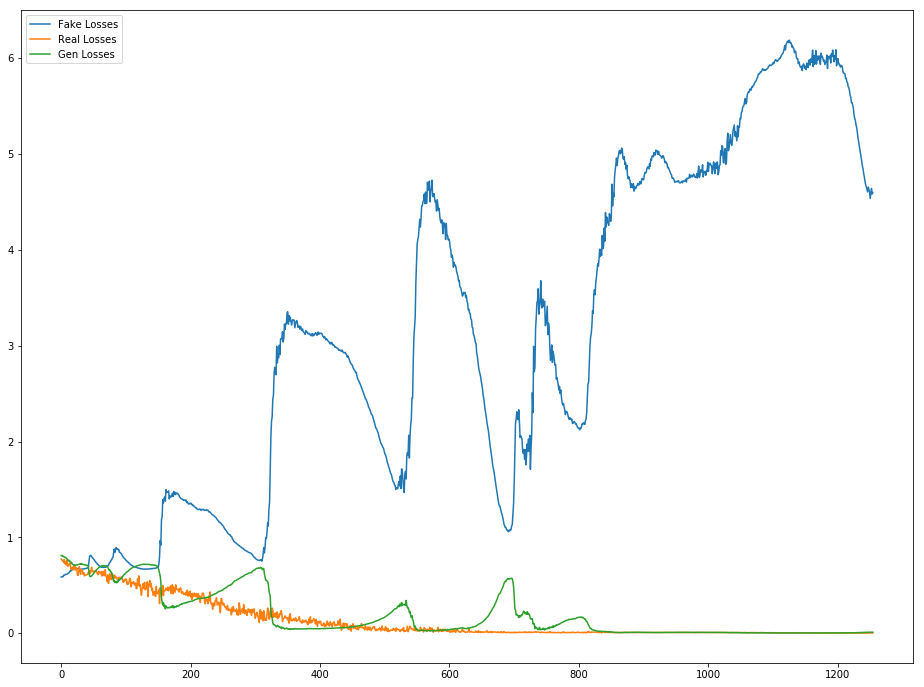

In [94]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(len(fake_losses)), fake_losses, label='Fake Losses')
plt.plot(np.arange(len(fake_losses)), real_losses, label='Real Losses')
plt.plot(np.arange(len(fake_losses)), gen_losses, label='Generator Losses')
plt.legend()

# GAN in Slim

In [95]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

tf.set_random_seed(219)
np.random.seed(219)

In [ ]:
# model = GAN_model(mode="train")
# model.build()

# # show info for trainable variables
# t_vars = tf.trainable_variables()
# slim.model_analyzer.analyze_vars(t_vars, print_info=True)

# with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
#   opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
# with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
#   opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
#                             var_list=model.G_vars)


# Useful Functions

* `load_image` loads an image given a path, and also crops it to a desired size

* `form_image_grid` is nice for plots and whatnot...

In [61]:
names = os.listdir(path_to_tripled_data + 'content/')

In [66]:
np.random.randint(low=0, high=len(names), size=4)

array([472, 910,  51, 314])

In [70]:
from data_processing_utils import *

In [71]:
load_xy_pairs(path_to_styled_images, path_to_styles, batch_size = 10, prob_of_real=1.0)

FailedPreconditionError: /Users/akhiljalan/Downloads/describable_textures_styles/images/smeared; Is a directory

In [7]:
load_image(path_to_styles + 'stained/stained_0015.jpg', image_size=25)

<tf.Tensor 'ExpandDims:0' shape=(1, 25, 25, 3) dtype=float32>

In [9]:
img_tensor = load_image(path_to_styles + 'stained/stained_0015.jpg')

In [10]:
img_tensor

<tf.Tensor 'ExpandDims_2:0' shape=(1, 360, 640, 3) dtype=float32>

In [12]:
form_image_grid(img_tensor, [1, 1], [360, 640], 3)

<tf.Tensor 'Reshape_5:0' shape=(1, 360, 640, 3) dtype=float32>

In [20]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

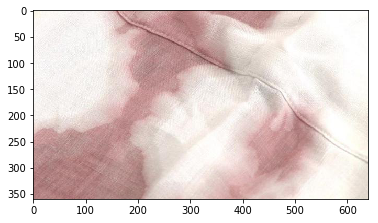

In [26]:
# with tf.Session() as sess: 
#     arr = sess.run([img_tensor])
# #     print(arr)
# #     print(len(arr))
# #     print(type(arr))
#     fig, a = plt.subplots(1, 2)
#     np_arr = np.array(arr).squeeze()
# #     Image.fromarray(np_arr, 'RGB').show()
#     #https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    
#     a=fig.subplots()
# img = mpimg.imread('../_static/stinkbug.png')
# lum_img = img[:,:,0]
# imgplot = plt.imshow(lum_img)
# a.set_title('Before')
# plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation ='horizontal')
#     a=fig.add_subplot(1,1,2)
# a=fig.add_subplot(1,2,2)
# imgplot = plt.imshow(lum_img)
# imgplot.set_clim(0.0,0.7)
# a.set_title('After')
# plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')

#     plt.imshow(np_arr)
# #     plt.gcf().clear()
# #     plt.imshow(-1 * np_arr)
# #     print(.shape)


# Stuff with OS

In [20]:
from data_processing_utils import *

In [11]:
load_xy_pairs(pbn_path, path_to_styled_images, batch_size=12)

(<tf.Tensor 'concat_20:0' shape=(12, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'concat_21:0' shape=(12, 2) dtype=float32>)

# Network Architecture 

## TODO

### Programming

1 Put everything into a Python file once it's cleaned up 

2 Train the discriminator independently, and in a "correct" way with respect to Tf 

3 Figure out how to update the generative model end to end 

## Complete Slim Steps 

Steps to a slim model (as according to `arbitrary_image_stylization_train.py`: 

1 `with tf.Graph().as_default():`

2 Declare device allocations, such as 

```
device = '/cpu:0' if not FLAGS.ps_tasks else '/job:worker/cpu:0'
    with tf.device(
        tf.train.replica_device_setter(FLAGS.ps_tasks, worker_device=device))
```

3 Get content, style inputs. Generally, load your inputs to the network.

4 Forward pass, to get the output(s) and loss(es). 

5 Declare your optimizer object, such as 

```
optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
```

6 Train operation, such as: 

```
train_op = slim.learning.create_train_op(
          total_loss,
          optimizer,
          clip_gradient_norm=FLAGS.clip_gradient_norm,
          summarize_gradients=False)
```

7 Run training, such as


```
slim.learning.train(
          train_op=train_op,
          logdir=os.path.expanduser(FLAGS.train_dir),
          master=FLAGS.master,
          is_chief=FLAGS.task == 0,
          number_of_steps=FLAGS.train_steps,
          init_fn=init_sub_networks,
          save_summaries_secs=FLAGS.save_summaries_secs,
          save_interval_secs=FLAGS.save_interval_secs)
```

8 Run, as in `tf.app.run()`

## Discriminator Network

TODO: 

* Use leaky relu in every layer 

* Use batch normalization 

* Consider using an all-convolutional network 

In [16]:
train_real_path = '/Users/akhiljalan/Downloads/train0/content_train/'
train_fake_path = '/Users/akhiljalan/Downloads/train0/identity_train/'
test_real_path = '/Users/akhiljalan/Downloads/train0/content_test/'
test_fake_path = '/Users/akhiljalan/Downloads/train0/identity_test/'

In [21]:
load_xy_pairs(train_fake_path, train_real_path, batch_size=16)

(<tf.Tensor 'concat_50:0' shape=(16, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'concat_51:0' shape=(16, 2) dtype=float32>)

In [26]:
# with tf.Graph().as_default(), tf.Session() as sess:

In [53]:
# tf.reset_default_graph()

In [33]:
# tf.reset_default_graph()

with tf.Graph().as_default() as graph, tf.Session() as sess:
    images, labels = load_xy_pairs(path_to_styled_images, pbn_path, batch_size=4)
    
#     global_step = tf.Variable(0, name='global_step',trainable=False)
    tf_global_step = tf.train.get_or_create_global_step()

    # TODO Create Test Set from a different directory. 
    
    #forward pass 
    def forward_pass(images): 
        conv1_out = slim.conv2d(images, 1, [5, 5], activation_fn=tf.nn.relu, scope='conv1')
        pool1_out = slim.max_pool2d(conv1_out, [2, 2], stride=2, scope='pool1')
        conv2_out = slim.conv2d(pool1_out, 1, [4, 4], stride=2, activation_fn=tf.nn.relu, scope='conv2')
        pool2_out = slim.max_pool2d(conv2_out, [6, 6], stride=3, padding='SAME', scope='pool2')
        flat_out = slim.flatten(pool2_out, scope='flatten3')
        fc1_out = slim.fully_connected(flat_out, 12, scope='fc1', activation_fn=tf.nn.relu)
        predictions = slim.fully_connected(fc1_out, 2, activation_fn=tf.nn.softmax)
        return predictions

    predictions = forward_pass(images) 
    
    # define optimizer, loss, etc. 
    optimizer = tf.train.AdamOptimizer(1e-4)
    cross_entropy_loss = slim.losses.softmax_cross_entropy(predictions, labels)
    
    # compute accuracy, where prediction is argmax 
    pred_classes = tf.argmax(predictions, axis=1)
    true_classes = tf.argmax(labels, axis=1)
    acc = slim.metrics.accuracy(pred_classes, true_classes)
    
    # compute confidence in more-probable class 
    confidence = tf.reduce_mean(tf.reduce_max(predictions, axis=1))
    
    train_op = slim.learning.create_train_op(cross_entropy_loss, 
                                             optimizer, 
                                             summarize_gradients=False, 
                                             global_step=tf_global_step) #false?
    
    # print stuff
    print('loss ', cross_entropy_loss)
    print('accuracy ', acc)
#     tf.summary.scalar('loss', cross_entropy_loss)
#     tf.summary.scalar('accuracy', acc)
    
#     if tf.train.global_step() % 50 == 0: 
    test_images, test_labels = load_xy_pairs(test_fake_path, test_real_path, batch_size=2)
#     with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    test_predictions = forward_pass(test_images)
    test_loss = slim.losses.softmax_cross_entropy(test_predictions, test_labels)

    # compute accuracy, where prediction is argmax 
    pred_test_classes = tf.argmax(test_predictions, axis=1)
    true_test_classes = tf.argmax(test_labels, axis=1)
    test_acc = slim.metrics.accuracy(pred_test_classes, true_test_classes)

    test_confidence = tf.reduce_mean(tf.reduce_max(test_predictions, axis=1))

    # print stuff
    print('test loss ', test_loss)
    print('test acc ', test_acc)
    print('test confidence ', test_confidence)
        
        
#     tf.summary.scalar('confidence', confidence)
#     tf.summary.FileWriter('./logdir/', graph)
    
#     tf.summary.text('time', tf.Tensor(, dtype=str))
    # run training 
    
    
    slim.learning.train(
          train_op=train_op,
#           logdir='./logdir/',
#           master=FLAGS.master,
#           is_chief=FLAGS.task == 0,
          number_of_steps=10)
#           init_fn=tf.global_variables_initializer(),
#           save_summaries_secs=10)
#           save_interval_secs=FLAGS.save_interval_secs)
    
    

('loss ', <tf.Tensor 'softmax_cross_entropy_loss/value:0' shape=() dtype=float32>)
('accuracy ', <tf.Tensor 'accuracy/Mean:0' shape=() dtype=float32>)


ValueError: Variable conv1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/akhiljalan/anaconda/envs/magenta/lib/python2.7/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 246, in variable
    use_resource=use_resource)
  File "/Users/akhiljalan/anaconda/envs/magenta/lib/python2.7/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "/Users/akhiljalan/anaconda/envs/magenta/lib/python2.7/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 291, in model_variable
    use_resource=use_resource)


In [18]:
import datetime

In [ ]:
# slim evaluation loop vs train loop? 

# slim.evaluation.evaluation_loop(
#         master=FLAGS.master,
#         checkpoint_dir=FLAGS.checkpoint_dir,
#         logdir=FLAGS.eval_dir,
#         eval_op=eval_op,
#         num_evals=num_evals,
#         eval_interval_secs=FLAGS.eval_interval_secs)

In [ ]:
# tf.summary.scalar('accuracy', accuracy)


In [16]:
# ALL TF SUMMARY SHIT

# time_now = datetime.datetime.now().isoformat()
# experiment_name = 'my_experiment_{}'.format(params)
# merged = tf.summary.merge_all()
# train_writer = tf.summary.FileWriter('./logdir/train/{}'.format(experiment_name), sess.graph)
# test_writer  = tf.summary.FileWriter('./logdir/test/{}'.format(experiment_name), sess.graph)

# summary, acc = sess.run([merged, accuracy], feed_dict={x: mnist.test.images,
#                                                                y_: mnist.test.labels})
#         test_writer.add_summary(summary, step)

In [6]:
# with tf.Graph().as_default():

## Adding scalar summaries to the tensorboard.
# for key, value in loss_dict.iteritems():
#         tf.summary.scalar(key, value)

# Adding Image summaries to the tensorboard.
#       tf.summary.image('image/0_content_inputs', content_inputs_, 3)
#       tf.summary.image('image/1_style_inputs_orig', style_inputs_orig_, 3)
#       tf.summary.image('image/2_style_inputs_aug', style_inputs_, 3)
#       tf.summary.image('image/3_stylized_images', stylized_images, 3)

# Set up training
#       optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
#       train_op = slim.learning.create_train_op(
#           total_loss,
#           optimizer,
#           clip_gradient_norm=FLAGS.clip_gradient_norm,
#           summarize_gradients=False)

# slim.learning.train(
#           train_op=train_op,
#           logdir=os.path.expanduser(FLAGS.train_dir),
#           master=FLAGS.master,
#           is_chief=FLAGS.task == 0,
#           number_of_steps=FLAGS.train_steps,
#           init_fn=init_sub_networks,
#           save_summaries_secs=FLAGS.save_summaries_secs,
#           save_interval_secs=FLAGS.save_interval_secs)

In [34]:
ls = ['aaa', 'bbb']

In [36]:
tf.__version__

'1.7.0'

In [ ]:
# # visualize.py
# #
# # to run
# # $ python visualize.py
# #
# # to use TensorBoard
# # $ tensorboard --logdir ./
# #
# import tensorflow as tf
# import datetime
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# x = tf.placeholder(tf.float32, shape=[None, 784])

# W = tf.get_variable("weights1", shape=[784, 10],
#                     initializer=tf.glorot_uniform_initializer())

# b = tf.get_variable("bias1", shape=[10],
#                     initializer=tf.constant_initializer(0.1))

# y = tf.nn.relu(tf.matmul(x, W) + b)

# y_ = tf.placeholder(tf.float32, [None, 10])

# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)
# train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

# correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# sess = tf.InteractiveSession()

# tf.summary.scalar('accuracy', accuracy)

# time_string = datetime.datetime.now().isoformat()
# experiment_name = f"one_hidden_layer_1000_steps_{time_string}"

# merged = tf.summary.merge_all()
# train_writer = tf.summary.FileWriter(f'./train/{experiment_name}', sess.graph)
# test_writer  = tf.summary.FileWriter(f'./test/{experiment_name}', sess.graph)

# tf.global_variables_initializer().run()

# for step in range(1000):
#     print(f"training step: {step}")
#     if step % 10 == 0:
#         summary, acc = sess.run([merged, accuracy], feed_dict={x: mnist.test.images,
#                                                                y_: mnist.test.labels})
#         test_writer.add_summary(summary, step)
#         print(f'Step {step}; Model accuracy: {acc}')
#     else:
#         batch_xs, batch_ys = mnist.train.next_batch(100)
#         sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys})
#         summary = sess.run(merged, feed_dict={x: batch_xs,
#                                               y_: batch_ys})
#         train_writer.add_summary(summary, step)
